# 📊 Case Study 01: Financial Report Analysis

<div align="right">
  <a href="https://colab.research.google.com/drive/1SnkavVR-h4ioorA_aIJKVarZh4JYuVZn?usp=sharing" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" style="height: 22px;"/>
  </a>
</div>

<div align="center">
  <img src="https://raw.githubusercontent.com/AdemBoukhris457/Doctra/main/assets/Doctra_Banner_MultiDoc.png" style="width: 100%; object-fit: cover;" alt="Doctra Banner">
</div>

## 🎯 Objective

This case study demonstrates how to use **Doctra** to extract and analyze financial data from PDF reports. We'll:

- Extract tables and charts from financial reports
- Convert visual elements to structured data using Vision Language Models (VLM)
- Analyze extracted financial data with pandas
- Generate insights from the extracted information

## 📋 Use Case

**Problem:** Financial reports often contain critical data in tables and charts that need to be extracted for analysis, but manual extraction is time-consuming and error-prone.

**Solution:** Use Doctra's structured parsing with VLM integration to automatically extract and convert financial tables and charts into structured formats (Excel, JSON) for further analysis.

## 🔑 Key Features Demonstrated

- ✅ **StructuredPDFParser**: Complete document parsing with layout detection
- ✅ **VLM Integration**: Convert charts and tables to structured data
- ✅ **ChartTablePDFParser**: Focused extraction of financial data
- ✅ **Data Analysis**: Analyze extracted data with pandas
- ✅ **Multi-format Output**: Excel, Markdown, HTML exports


## 📦 Installation

First, let's install Doctra and required dependencies:


In [1]:
# Install Doctra
! pip install doctra pandas openpyxl matplotlib seaborn

### System Dependencies

For PDF processing, we need Poppler utilities:


In [26]:
# Poppler utilities installation
# Note: Poppler is required for PDF processing
# 
# For Google Colab, run this in a separate cell:
#   !sudo apt-get install -y poppler-utils
#
# For local installation:
#   Ubuntu/Debian: sudo apt-get install poppler-utils
#   macOS: brew install poppler
#   Windows: Download from https://poppler.freedesktop.org/ or use conda:
#            conda install -c conda-forge poppler

print("ℹ️  If you encounter PDF processing errors, install poppler-utils:")
print("   Colab: !sudo apt-get install -y poppler-utils")
print("   Linux: sudo apt-get install poppler-utils")
print("   macOS: brew install poppler")

ℹ️  If you encounter PDF processing errors, install poppler-utils:
   Colab: !sudo apt-get install -y poppler-utils
   Linux: sudo apt-get install poppler-utils
   macOS: brew install poppler


## 🔧 Setup and Configuration

Let's import the necessary libraries and set up our environment:


In [27]:
import os
from pathlib import Path
import pandas as pd
import json
from IPython.display import Image, display, Markdown
import warnings
warnings.filterwarnings('ignore')

# Doctra imports
from doctra.parsers.structured_pdf_parser import StructuredPDFParser
from doctra.parsers.table_chart_extractor import ChartTablePDFParser
from doctra.engines.vlm.service import VLMStructuredExtractor

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


### VLM Configuration (Optional)

To extract structured data from charts and tables, you can configure a Vision Language Model. 

**Note:** VLM is optional but recommended for converting visual charts to structured data. You can skip this section if you only need to extract text and images.

Supported providers:
- `openai` - OpenAI GPT-4 Vision
- `gemini` - Google Gemini
- `anthropic` - Anthropic Claude
- `openrouter` - OpenRouter
- `qianfan` - Baidu Qianfan
- `ollama` - Local Ollama models


In [ ]:
api_key = ""

In [29]:
# VLM Configuration (Optional)
# Uncomment and configure if you want to use VLM for structured data extraction

USE_VLM = True  # Set to True to enable VLM
VLM_PROVIDER = "openai"  # or "gemini", "anthropic", etc.
VLM_API_KEY = os.getenv("OPENAI_API_KEY", api_key)  # Set your API key here or use environment variable

# Initialize VLM engine if enabled
vlm_engine = None
if USE_VLM and VLM_API_KEY:
    try:
        vlm_engine = VLMStructuredExtractor(
            vlm_provider=VLM_PROVIDER,
            vlm_model="gpt-5-mini-2025-08-07",
            api_key=VLM_API_KEY
        )
        print(f"✅ VLM engine initialized with provider: {VLM_PROVIDER}")
    except Exception as e:
        print(f"⚠️  VLM initialization failed: {e}")
        print("Continuing without VLM...")
        vlm_engine = None
else:
    print("ℹ️  VLM disabled. Charts and tables will be extracted as images only.")
    print("   To enable VLM, set USE_VLM=True and provide an API key.")

✅ VLM engine initialized with provider: openai


## 📄 Step 1: Load Sample Financial Report

Let's use a sample financial report for this case study:


In [30]:
# Find sample financial report
sample_data_dir = Path("sample_data")
notebooks_sample_dir = Path("notebooks/sample_data")

# Try to find the financial report
pdf_path = None
for dir_path in [sample_data_dir, notebooks_sample_dir]:
    if dir_path.exists():
        potential_files = list(dir_path.glob("*financial*.pdf"))
        if potential_files:
            pdf_path = str(potential_files[0])
            break

if pdf_path and Path(pdf_path).exists():
    print(f"✅ Found financial report: {pdf_path}")
    print(f"📊 File size: {Path(pdf_path).stat().st_size / 1024:.2f} KB")
else:
    print("⚠️  Sample financial report not found.")
    print("   Please provide a PDF path:")
    pdf_path = input("Enter PDF path: ").strip()
    
print(f"\n📄 Will process: {pdf_path}")

✅ Found financial report: sample_data\wipo_financial_report_min.pdf
📊 File size: 566.50 KB

📄 Will process: sample_data\wipo_financial_report_min.pdf


🔄 Loading PaddleOCR layout model: "PP-DocLayout_plus-L": 100%|██████████| 1/1 [00:01<00:00]



📊 Layout Detection Summary for wipo_financial_report_min.pdf:
Pages processed: 2

Total elements detected:
  - chart: 2
  - figure_title: 3
  - header: 2
  - number: 2
  - paragraph_title: 1
  - table: 2
  - text: 9


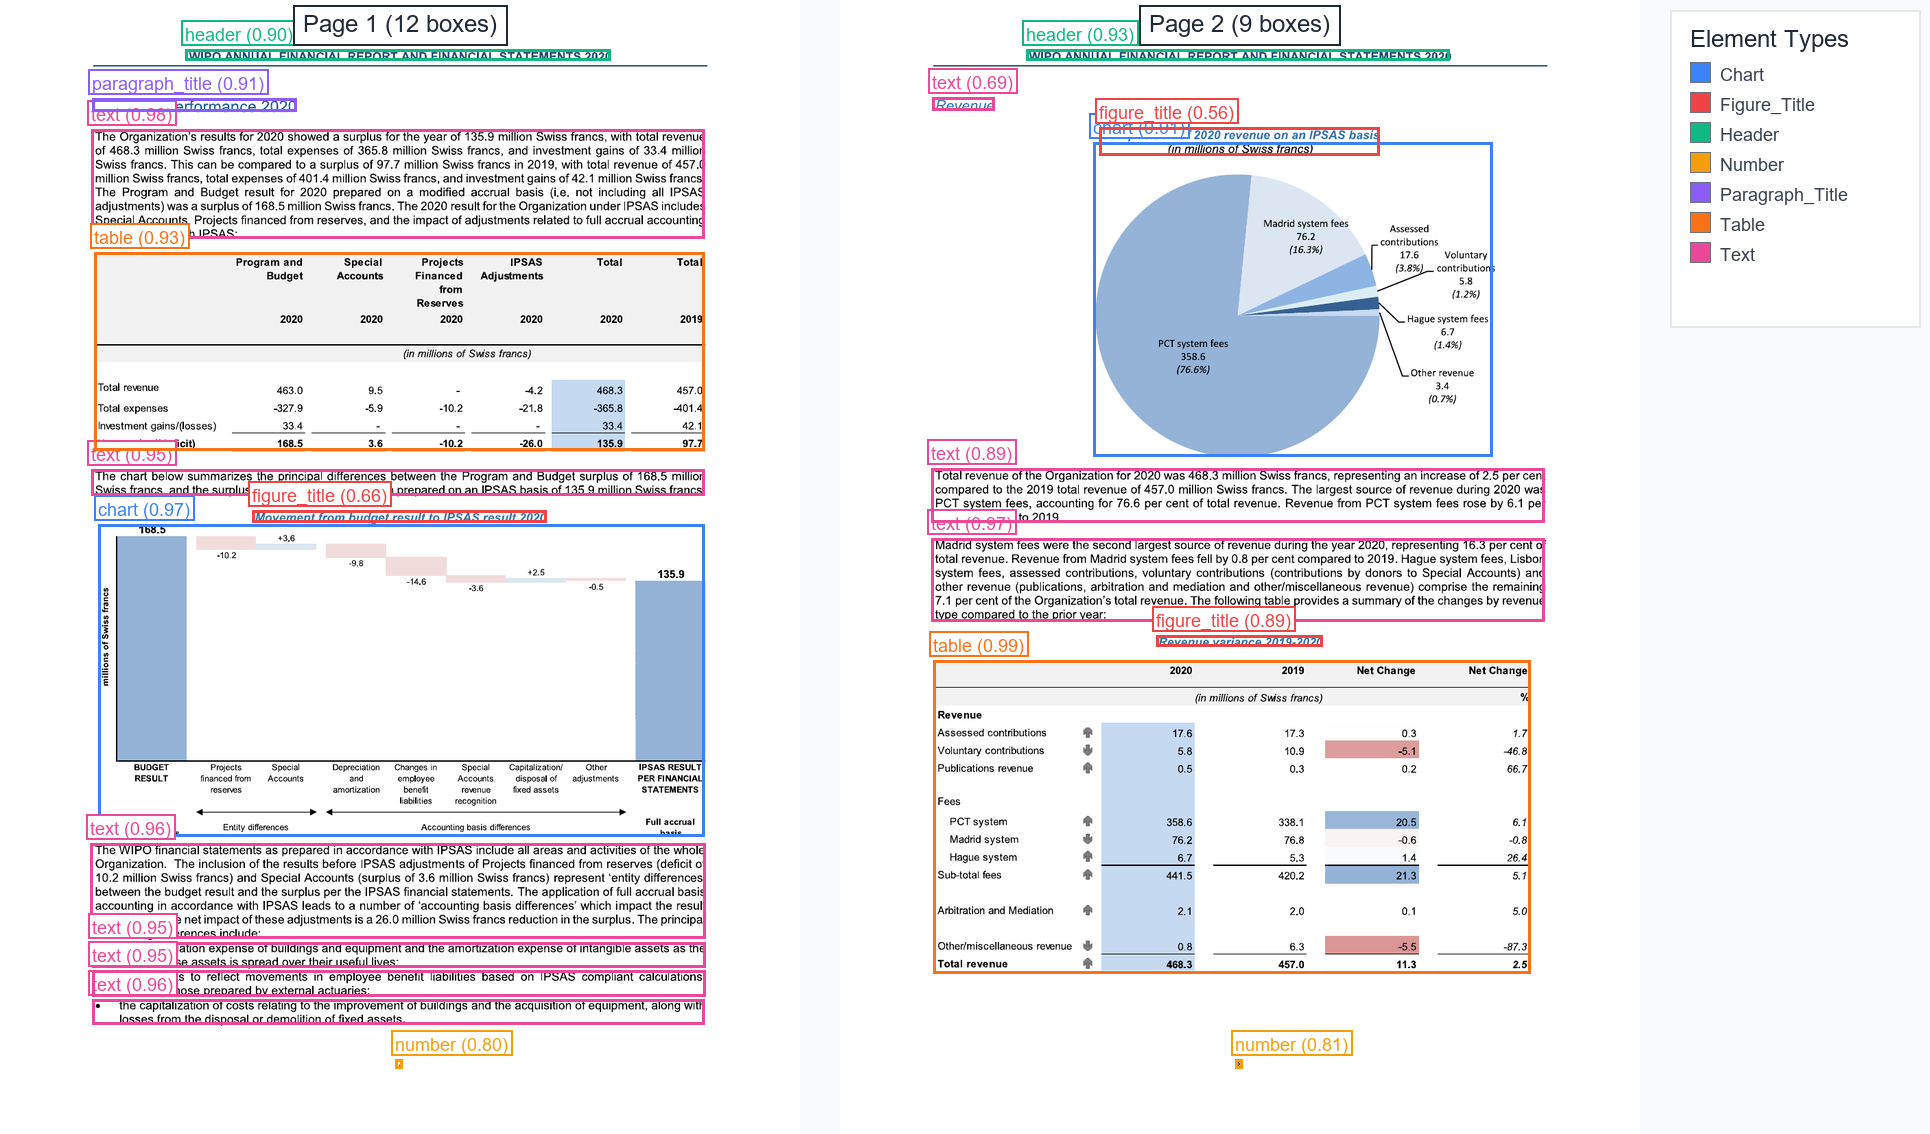

In [42]:
from doctra.parsers.structured_pdf_parser import StructuredPDFParser

# use basic parser without VLM
parser = StructuredPDFParser()

parser.display_pages_with_boxes(
    pdf_path=pdf_path,
    num_pages=2
)

## 🔍 Step 2: Extract Tables and Charts

We'll use `ChartTablePDFParser` to focus specifically on extracting financial tables and charts. This is more efficient than full document parsing when you only need structured data.


In [34]:
# Initialize ChartTablePDFParser
# This parser is optimized for extracting only tables and charts
parser = ChartTablePDFParser(
    extract_charts=True,   # Extract charts
    extract_tables=True,   # Extract tables
    vlm=vlm_engine,        # Pass VLM engine if configured
    dpi=200,               # Resolution for processing
    min_score=0.0          # Minimum confidence threshold
)

print("✅ Parser initialized")
print(f"   - Extract charts: {parser.extract_charts}")
print(f"   - Extract tables: {parser.extract_tables}")
print(f"   - VLM enabled: {vlm_engine is not None}")

✅ Parser initialized
   - Extract charts: True
   - Extract tables: True
   - VLM enabled: True


In [33]:
# Parse the financial report
print(f"🔄 Processing {Path(pdf_path).name}...")
print("   This may take a few minutes depending on document size and VLM usage...\n")

try:
    parser.parse(pdf_path)
    print("✅ Parsing completed successfully!")
except Exception as e:
    print(f"❌ Error during parsing: {e}")
    raise

🔄 Processing wipo_financial_report_min.pdf...
   This may take a few minutes depending on document size and VLM usage...



🔄 Loading PaddleOCR layout model: "PP-DocLayout_plus-L": 100%|██████████| 1/1 [00:01<00:00]
🤖 Charts (VLM → table): 100%|██████████| 2/2 [01:22<00:00]


✅ Parsing completed successfully!
📁 Output directory: outputs\wipo_financial_report_min\structured_parsing
✅ Parsing completed successfully!


## 📁 Step 3: Explore Extracted Output

Let's examine what was extracted from the financial report:


In [35]:
from pathlib import Path
import pandas as pd

# Find the output directory
pdf_name = Path(pdf_path).stem
output_dir = Path("outputs") / pdf_name / "structured_parsing"

if not output_dir.exists():
    # Try alternative location
    output_dir = Path("outputs") / pdf_name
    if not output_dir.exists():
        # Find the most recent output
        outputs_root = Path("outputs")
        if outputs_root.exists():
            candidates = sorted(outputs_root.glob("*/"), key=lambda p: p.stat().st_mtime, reverse=True)
            if candidates:
                output_dir = candidates[0] / "structured_parsing"
                if not output_dir.exists():
                    output_dir = candidates[0]

if output_dir.exists():
    print(f"📁 Output directory: {output_dir}")
    print("\n📋 Contents:")
    
    # List all extracted files
    for item in sorted(output_dir.rglob("*")):
        if item.is_file():
            size = item.stat().st_size
            rel_path = item.relative_to(output_dir)
            print(f"  📄 {rel_path} ({size:,} bytes)")
else:
    print(f"⚠️  Output directory not found: {output_dir}")
    print("   Please check if parsing completed successfully.")

📁 Output directory: outputs\wipo_financial_report_min\structured_parsing

📋 Contents:
  📄 charts\chart_001.png (30,854 bytes)
  📄 charts\chart_002.png (33,323 bytes)
  📄 parsed_tables_charts.html (30,784 bytes)
  📄 parsed_tables_charts.xlsx (9,954 bytes)
  📄 tables\table_001.png (35,455 bytes)
  📄 tables\table_002.png (54,589 bytes)
  📄 vlm_items.json (4,197 bytes)


### Check for Extracted Tables (Excel/JSON)

If VLM was enabled, we should have structured data files:


In [36]:
# Check for Excel file with extracted tables
excel_files = list(output_dir.glob("*.xlsx")) if output_dir.exists() else []
json_files = list(output_dir.glob("*.json")) if output_dir.exists() else []

if excel_files:
    excel_path = excel_files[0]
    print(f"✅ Found Excel file: {excel_path.name}")
    print("📊 Loading extracted tables...\n")
    
    # Load Excel file
    xl_file = pd.ExcelFile(excel_path)
    
    # Check for TOC/Summary sheet
    toc_sheet_names = ["Table Summary", "Summary", "TOC", "Contents", "Table of Contents"]
    has_toc = any(any(toc_name.lower() in sheet.lower() for toc_name in toc_sheet_names) 
                  for sheet in xl_file.sheet_names)
    
    print(f"📑 Sheets in Excel file ({len(xl_file.sheet_names)} total):")
    if has_toc:
        print("   📑 Includes Table of Contents / Summary sheet")
    
    for i, sheet_name in enumerate(xl_file.sheet_names, 1):
        try:
            df = pd.read_excel(excel_path, sheet_name=sheet_name)
            sheet_type = "📑 TOC" if any(toc_name.lower() in sheet_name.lower() for toc_name in toc_sheet_names) else "📊 Table"
            print(f"  {i}. {sheet_type} - {sheet_name}: {df.shape[0]} rows × {df.shape[1]} columns")
        except Exception as e:
            print(f"  {i}. {sheet_name}: Error loading - {e}")
elif json_files:
    print(f"✅ Found JSON file: {json_files[0].name}")
    with open(json_files[0], 'r') as f:
        data = json.load(f)
    print(f"📊 Found {len(data)} extracted items")
else:
    print("ℹ️  No structured data files found (Excel/JSON).")
    print("   This is normal if VLM was not enabled.")
    print("   Tables and charts were extracted as images instead.")

✅ Found Excel file: parsed_tables_charts.xlsx
📊 Loading extracted tables...

📑 Sheets in Excel file (5 total):
   📑 Includes Table of Contents / Summary sheet
  1. 📑 TOC - Table Summary: 4 rows × 4 columns
  2. 📊 Table - Revenue and Expenses 2020: 4 rows × 7 columns
  3. 📊 Table - Budget to IPSAS Result Waterall: 9 rows × 2 columns
  4. 📊 Table - Revenue by Source (CHF m): 6 rows × 3 columns
  5. 📊 Table - Revenue and Fees (2020 vs 2019): 10 rows × 5 columns


## 📈 Step 4: Analyze Extracted Financial Tables

Let's load and analyze the extracted financial data:


In [37]:
# Load and display extracted tables
if excel_files:
    excel_path = excel_files[0]
    xl_file = pd.ExcelFile(excel_path)
    
    # Separate TOC/Summary sheet (first sheet) from data sheets
    toc_sheet_names = ["Table Summary", "Summary", "TOC", "Contents", "Table of Contents"]
    all_sheets = xl_file.sheet_names
    toc_sheet = None
    data_sheets = []
    
    # The first sheet is typically the TOC
    if all_sheets:
        first_sheet = all_sheets[0]
        if any(toc_name.lower() in first_sheet.lower() for toc_name in toc_sheet_names):
            toc_sheet = first_sheet
            data_sheets = all_sheets[1:]  # All sheets after the first one
        else:
            # If first sheet doesn't match TOC pattern, check all sheets
            for sheet_name in all_sheets:
                if any(toc_name.lower() in sheet_name.lower() for toc_name in toc_sheet_names):
                    toc_sheet = sheet_name
                else:
                    data_sheets.append(sheet_name)
    
    # Load TOC and create mapping from table title to description
    sheet_descriptions = {}
    if toc_sheet:
        try:
            df_toc = pd.read_excel(excel_path, sheet_name=toc_sheet)
            
            # Display TOC first
            print(f"\n{'='*80}")
            print(f"📑 Table of Contents / Summary")
            print(f"{'='*80}")
            display(df_toc)
            print(f"\n{'='*80}\n")
            
            # Create mapping: table title -> description
            # Look for columns that might contain title and description
            title_col = None
            desc_col = None
            
            # Common column names for title and description
            for col in df_toc.columns:
                col_lower = str(col).lower()
                if 'title' in col_lower or 'table' in col_lower or 'name' in col_lower:
                    title_col = col
                if 'description' in col_lower or 'desc' in col_lower:
                    desc_col = col
            
            # If standard columns not found, use first two columns
            if title_col is None or desc_col is None:
                cols = list(df_toc.columns)
                if len(cols) >= 2:
                    title_col = cols[0] if title_col is None else title_col
                    desc_col = cols[1] if desc_col is None else desc_col
            
            # Build mapping
            if title_col and desc_col:
                for _, row in df_toc.iterrows():
                    title = str(row.get(title_col, '')).strip()
                    description = str(row.get(desc_col, '')).strip()
                    if title and description:
                        sheet_descriptions[title] = description
                        
        except Exception as e:
            print(f"\n❌ Error loading TOC sheet '{toc_sheet}': {e}\n")
    
    # Display each data sheet with its description
    for sheet_name in data_sheets:
        try:
            df = pd.read_excel(excel_path, sheet_name=sheet_name)
            
            print(f"\n{'='*80}")
            print(f"📊 {sheet_name}")
            print(f"{'='*80}")
            
            # Find and display description from TOC
            description = sheet_descriptions.get(sheet_name, None)
            if not description:
                # Try partial matching (sheet name might be shortened version of title)
                for title, desc in sheet_descriptions.items():
                    if sheet_name.lower() in title.lower() or title.lower() in sheet_name.lower():
                        description = desc
                        break
            
            if description:
                print(f"\n📝 Description:")
                print(f"   {description}\n")
            else:
                print(f"\n📝 Description: Not available\n")
            
            # Display the dataframe
            print(f"📋 Extracted Data:\n")
            display(df)
            
            print(f"\n   ℹ️  Shape: {df.shape[0]} rows × {df.shape[1]} columns")
                
        except Exception as e:
            print(f"\n❌ Error loading sheet '{sheet_name}': {e}")
else:
    print("ℹ️  No Excel file available for analysis.")
    print("   Enable VLM to extract structured data from tables and charts.")


📑 Table of Contents / Summary


,Table Title,Description,Page,Type
0,Revenue and Expenses 2020,"Summary of 2020 revenue, expenses, investment ...",1,Table
1,Budget to IPSAS Result Waterall,Waterfall reconciliation from the budget resul...,1,Chart
2,Revenue by Source (CHF m),Pie chart showing revenue breakdown by source ...,2,Chart
3,Revenue and Fees (2020 vs 2019),Revenue and fee income by category for 2020 an...,2,Table





📊 Revenue and Expenses 2020

📝 Description:
   Summary of 2020 revenue, expenses, investment gains/(losses) and net surplus/(deficit) across Program & Budget, Special Accounts, Projects financed from reserves and IPSAS adjustments, with total for 2020 and a 2019 comparison.

📋 Extracted Data:



,Line item,Program and Budget 2020,Special Accounts 2020,Projects Financed from Reserves 2020,IPSAS Adjustments 2020,Total 2020,Total 2019
0,Total revenue,463.0,9.5,-,-4.2,468.3,457.0
1,Total expenses,-327.9,-5.9,-10.2,-21.8,-365.8,-401.4
2,Investment gains/(losses),33.4,-,-,-,33.4,42.1
3,Net surplus/(deficit),168.5,3.6,-10.2,-26.0,135.9,97.7



   ℹ️  Shape: 4 rows × 7 columns

📊 Budget to IPSAS Result Waterall

📝 Description:
   Waterfall reconciliation from the budget result (modified accrual) through individual adjustments to the IPSAS result (full accrual). Amounts are shown in millions of Swiss francs and reflect each adjustment applied to the starting budget result.

📋 Extracted Data:



,Item,Amount (millions of Swiss francs)
0,Budget result (modified accrual basis),168.5
1,Projects financed from reserves,-10.2
2,Special Accounts,3.6
3,Depreciation and amortization,-9.8
4,Changes in employee benefit liabilities,-14.6
5,Special Accounts revenue recognition,-3.6
6,Capitalization/disposal of fixed assets,2.5
7,Other adjustments,-0.5
8,IPSAS result per financial statements (full ac...,135.9



   ℹ️  Shape: 9 rows × 2 columns

📊 Revenue by Source (CHF m)

📝 Description:
   Pie chart showing revenue breakdown by source (in millions of Swiss francs). PCT and Madrid system fees are the largest shares, with smaller contributions from assessed, Hague, voluntary and other revenues.

📋 Extracted Data:



,Category,Amount (millions CHF),Percentage
0,PCT system fees,358.6,76.6%
1,Madrid system fees,76.2,16.3%
2,Assessed contributions,17.6,3.8%
3,Hague system fees,6.7,1.4%
4,Voluntary contributions,5.8,1.2%
5,Other revenue,3.4,0.7%



   ℹ️  Shape: 6 rows × 3 columns

📊 Revenue and Fees (2020 vs 2019)

📝 Description:
   Revenue and fee income by category for 2020 and 2019 (in millions of Swiss francs), showing absolute net change and percentage change for each line item.

📋 Extracted Data:



,Item,2020,2019,Net Change (CHF),Net Change (%)
0,Assessed contributions,17.6,17.3,0.3,1.7
1,Voluntary contributions,5.8,10.9,-5.1,-46.8
2,Publications revenue,0.5,0.3,0.2,66.7
3,PCT system,358.6,338.1,20.5,6.1
4,Madrid system,76.2,76.8,-0.6,-0.8
5,Hague system,6.7,5.3,1.4,26.4
6,Sub-total fees,441.5,420.2,21.3,5.1
7,Arbitration and Mediation,2.1,2.0,0.1,5.0
8,Other/miscellaneous revenue,0.8,6.3,-5.5,-87.3
9,Total revenue,468.3,457.0,11.3,2.5



   ℹ️  Shape: 10 rows × 5 columns


## 🖼️ Step 5: View Extracted Visual Elements

Even without VLM, Doctra extracts tables and charts as images. Let's view them:


📊 Found 2 extracted tables:

Table 1: table_001.png


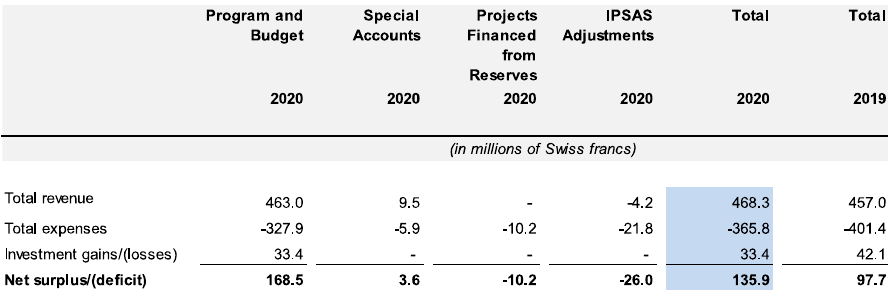


Table 2: table_002.png


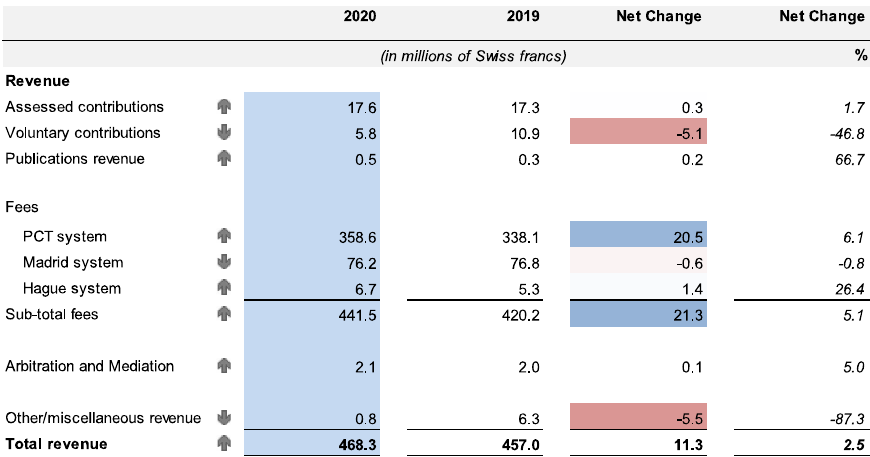



📈 Found 2 extracted charts:

Chart 1: chart_001.png


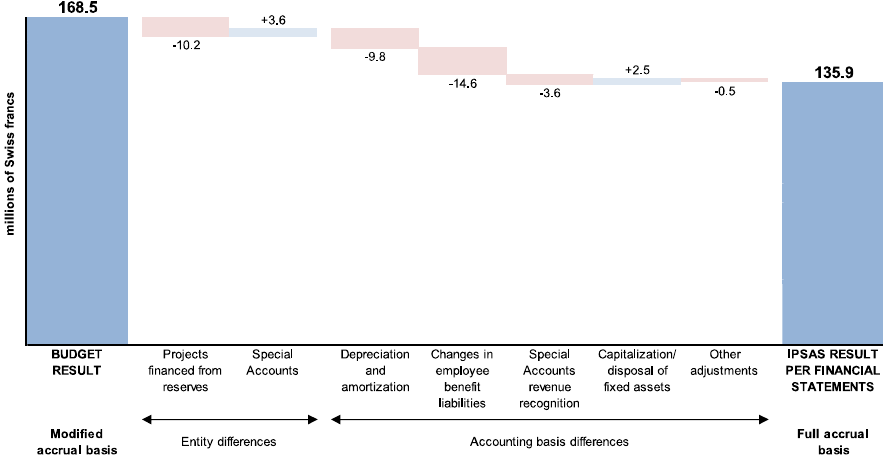


Chart 2: chart_002.png


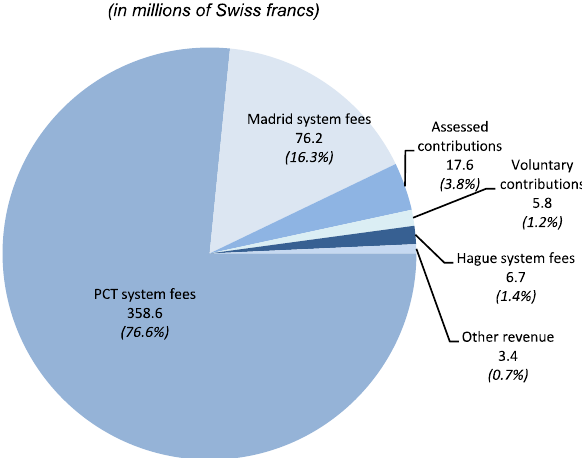

In [38]:
from IPython.display import Image, display
from pathlib import Path

# Find extracted images
tables_dir = output_dir / "tables" if output_dir.exists() else None
charts_dir = output_dir / "charts" if output_dir.exists() else None

# Display extracted tables
if tables_dir and tables_dir.exists():
    table_images = sorted(list(tables_dir.glob("*.png")) + list(tables_dir.glob("*.jpg")))
    if table_images:
        print(f"📊 Found {len(table_images)} extracted tables:\n")
        for i, img_path in enumerate(table_images[:5], 1):  # Show first 5
            print(f"Table {i}: {img_path.name}")
            try:
                display(Image(str(img_path), width=700))
            except Exception as e:
                print(f"   ⚠️  Could not display: {e}")
            print()
    else:
        print("ℹ️  No table images found in tables directory")
else:
    print("ℹ️  Tables directory not found")

# Display extracted charts
if charts_dir and charts_dir.exists():
    chart_images = sorted(list(charts_dir.glob("*.png")) + list(charts_dir.glob("*.jpg")))
    if chart_images:
        print(f"\n📈 Found {len(chart_images)} extracted charts:\n")
        for i, img_path in enumerate(chart_images[:5], 1):  # Show first 5
            print(f"Chart {i}: {img_path.name}")
            try:
                display(Image(str(img_path), width=700))
            except Exception as e:
                print(f"   ⚠️  Could not display: {e}")
            print()
    else:
        print("\nℹ️  No chart images found in charts directory")
else:
    print("\nℹ️  Charts directory not found")

## 🔄 Step 6: Alternative - Full Document Parsing

For a more comprehensive extraction (including all text, figures, etc.), we can use `StructuredPDFParser`:


In [39]:
# Option: Use StructuredPDFParser for full document parsing
# This extracts everything: text, tables, charts, figures, etc.

USE_FULL_PARSER = True  # Set to True to run full parsing

if USE_FULL_PARSER:
    print("🔄 Running full document parsing...")
    
    # Initialize full parser
    full_parser = StructuredPDFParser(
        vlm=vlm_engine,  # Pass VLM if available
        dpi=200,
        min_score=0.0
    )
    
    try:
        full_parser.parse(pdf_path)
        print("✅ Full parsing completed!")
        
        # Full parse output location
        full_output_dir = Path("outputs") / pdf_name / "full_parse"
        if full_output_dir.exists():
            print(f"\n📁 Full parse output: {full_output_dir}")
            
            # Check for markdown/html outputs
            md_file = full_output_dir / "result.md"
            html_file = full_output_dir / "result.html"
            
            if md_file.exists():
                print(f"   ✅ Markdown: {md_file}")
            if html_file.exists():
                print(f"   ✅ HTML: {html_file}")
    except Exception as e:
        print(f"❌ Error: {e}")
else:
    print("ℹ️  Full parsing skipped (set USE_FULL_PARSER=True to enable)")
    print("   Using ChartTablePDFParser is more efficient for table/chart extraction only.")

🔄 Running full document parsing...


🔄 Loading PaddleOCR layout model: "PP-DocLayout_plus-L": 100%|██████████| 1/1 [00:03<00:00]
🤖 Charts (VLM → table): 100%|██████████| 2/2 [01:27<00:00]


✅ Parsing completed successfully!
📁 Output directory: outputs/wipo_financial_report_min/full_parse
✅ Full parsing completed!

📁 Full parse output: outputs\wipo_financial_report_min\full_parse
   ✅ Markdown: outputs\wipo_financial_report_min\full_parse\result.md
   ✅ HTML: outputs\wipo_financial_report_min\full_parse\result.html


## 📊 Step 7: Data Analysis Example

If we have extracted structured data, let's perform some basic financial analysis:


In [40]:
# Example: Analyze extracted financial data
if excel_files:
    excel_path = excel_files[0]
    xl_file = pd.ExcelFile(excel_path)
    
    print("📊 Financial Data Analysis\n")
    print("="*80)
    
    # Load all sheets into a dictionary
    all_tables = {}
    for sheet_name in xl_file.sheet_names:
        try:
            df = pd.read_excel(excel_path, sheet_name=sheet_name)
            all_tables[sheet_name] = df
        except:
            continue
    
    # Example analysis: Find numeric columns and calculate totals
    for name, df in all_tables.items():
        numeric_cols = df.select_dtypes(include=['number']).columns
        
        if len(numeric_cols) > 0:
            print(f"\n📈 Analysis for: {name}")
            print("-" * 80)
            
            # Calculate sum for each numeric column
            print("Column Totals:")
            for col in numeric_cols:
                total = df[col].sum()
                mean = df[col].mean()
                print(f"  • {col}: Sum={total:,.2f}, Mean={mean:,.2f}")
            
            # Find largest values
            print("\nTop 5 Largest Values:")
            for col in numeric_cols[:3]:  # First 3 numeric columns
                top_values = df.nlargest(5, col)[[col]]
                print(f"\n  {col}:")
                print(top_values.to_string())
else:
    print("ℹ️  No structured data available for analysis.")
    print("   Enable VLM to extract structured data from tables.")

📊 Financial Data Analysis


📈 Analysis for: Table Summary
--------------------------------------------------------------------------------
Column Totals:
  • Page: Sum=6.00, Mean=1.50

Top 5 Largest Values:

  Page:
   Page
3     2
2     2
1     1
0     1

📈 Analysis for: Revenue and Expenses 2020
--------------------------------------------------------------------------------
Column Totals:
  • Program and Budget 2020: Sum=337.00, Mean=84.25
  • Total 2020: Sum=271.80, Mean=67.95
  • Total 2019: Sum=195.40, Mean=48.85

Top 5 Largest Values:

  Program and Budget 2020:
   Program and Budget 2020
0                    463.0
3                    168.5
2                     33.4
1                   -327.9

  Total 2020:
   Total 2020
0       468.3
3       135.9
2        33.4
1      -365.8

  Total 2019:
   Total 2019
0       457.0
3        97.7
2        42.1
1      -401.4

📈 Analysis for: Budget to IPSAS Result Waterall
----------------------------------------------------------------------

## 📄 Step 8: Display Full Document Markdown

Let's view the complete markdown output from StructuredPDFParser (if available):


In [41]:
# Display markdown file from StructuredPDFParser (if available)
from IPython.display import Markdown, display

# Find the full_parse output directory
pdf_name = Path(pdf_path).stem if pdf_path else None
full_parse_dir = None

if pdf_name:
    full_parse_dir = Path("outputs") / pdf_name / "full_parse"
    if not full_parse_dir.exists():
        # Try to find the most recent full_parse directory
        outputs_root = Path("outputs")
        if outputs_root.exists():
            candidates = sorted(outputs_root.glob("*/full_parse/"), key=lambda p: p.stat().st_mtime, reverse=True)
            if candidates:
                full_parse_dir = candidates[0]

# Look for markdown file
md_file = None
if full_parse_dir and full_parse_dir.exists():
    md_files = list(full_parse_dir.glob("*.md"))
    if md_files:
        md_file = md_files[0]  # Usually result.md

if md_file and md_file.exists():
    try:
        print(f"📄 Loading markdown file: {md_file.name}")
        print(f"📁 Location: {md_file.parent}\n")
        print(f"{'='*80}\n")
        
        # Read and display markdown content
        with open(md_file, 'r', encoding='utf-8', errors='ignore') as f:
            md_content = f.read()
        
        # Display as markdown
        display(Markdown(md_content))
        
        print(f"\n{'='*80}")
        print(f"✅ Markdown file displayed successfully")
        print(f"📊 File size: {md_file.stat().st_size / 1024:.2f} KB")
        
    except Exception as e:
        print(f"❌ Error reading markdown file: {e}")
        print(f"\n💡 Tip: Run StructuredPDFParser to generate the full markdown output.")
        print(f"   You can use the 'Step 6: Alternative - Full Document Parsing' section above.")
else:
    print("ℹ️  Markdown file from StructuredPDFParser not found.")
    print(f"   Expected location: outputs/{pdf_name}/full_parse/result.md" if pdf_name else "   PDF name not available")
    print(f"\n💡 Tip: To generate the markdown file, run StructuredPDFParser:")
    print(f"   - Set USE_FULL_PARSER=True in Step 6")
    print(f"   - Or run StructuredPDFParser separately")


📄 Loading markdown file: result.md
📁 Location: outputs\wipo_financial_report_min\full_parse




# Extracted Content

## Page 1

WIPO ANNUAL FINANCIAL REPORT AND FINANCIAL STATEMENTS 2020

Financial Performance 2020

The Organization’s results for 2020 showed a surplus for the year of 135.9 million Swiss francs, with total revenue
of 468.3 million Swiss francs, total expenses of 365.8 million Swiss francs, and investment gains of 33.4 million
Swiss francs. This can be compared to a surplus of 97.7 million Swiss francs in 2019, with total revenue of 457.0
million Swiss francs, total expenses of 401.4 million Swiss francs, and investment gains of 42.1 million Swiss francs.
The Program and Budget result for 2020 prepared on a modified accrual basis (i.e. not including all IPSAS
adjustments) was a surplus of 168.5 million Swiss francs. The 2020 result for the Organization under IPSAS includes
Special Accounts, Projects financed from reserves, and the impact of adjustments related to full accrual accounting
in accordance with IPSAS:

**Program Financial Summary 2020**
| Category | Program and Budget (2020) | Special Accounts (2020) | Projects Financed from Reserves (2020) | IPSAS Adjustments (2020) | Total (2020) | Total (2019) |
| --- | --- | --- | --- | --- | --- | --- |
| Total revenue | 463.0 | 9.5 | - | -4.2 | 468.3 | 457.0 |
| Total expenses | -327.9 | -5.9 | -10.2 | -21.8 | -365.8 | -401.4 |
| Investment gains/(losses) | 33.4 | - | - | - | 33.4 | 42.1 |
| Net surplus/(deficit) | 168.5 | 3.6 | -10.2 | -26.0 | 135.9 | 97.7 |

The chart below summarizes the principal differences between the Program and Budget surplus of 168.5 million
Swiss francs, and the surplus for the whole Organization prepared on an IPSAS basis of 135.9 million Swiss francs:

Movement from budaet result to IPSAS result 2020

**Budget to IPSAS Reconciliation**
| Item | Amount (millions of Swiss francs) |
| --- | --- |
| BUDGET RESULT | 168.5 |
| Projects financed from reserves | -10.2 |
| Special Accounts (entity differences) | +3.6 |
| Depreciation and amortization | -9.8 |
| Changes in employee benefit liabilities | -14.6 |
| Special Accounts revenue recognition | -3.6 |
| Capitalization/disposal of fixed assets | +2.5 |
| Other adjustments | -0.5 |
| IPSAS RESULT PER FINANCIAL STATEMENTS | 135.9 |

The WIPO financial statements as prepared in accordance with IPSAS include all areas and activities of the whole
Organization. The inclusion of the results before IPSAS adjustments of Projects financed from reserves (deficit of
10.2 million Swiss francs) and Special Accounts (surplus of 3.6 million Swiss francs) represent ‘entity differences’
between the budget result and the surplus per the IPSAS financial statements. The application of full accrual basis
accounting in accordance with IPSAS leads to a number of ‘accounting basis differences’ which impact the result
for the year. The net impact of these adjustments is a 26.0 million Swiss francs reduction in the surplus. The principal
accounting differences include:

* _ the depreciation expense of buildings and equipment and the amortization expense of intangible assets as the
cost of these assets is spread over their useful lives:

* adjustments to reflect movements in employee benefit liabilities based on IPSAS compliant calculations,
includina those prepared by external actuaries:

* _ the capitalization of costs relating to the improvement of buildings and the acquisition of equipment, along with
losses from the disposal or demolition of fixed assets.

## Page 2

WIPO ANNUAL FINANCIAL REPORT AND FINANCIAL STATEMENTS 2020

Revenue

Composition of 2020 revenue on an IPSAS basis
(in millions of Swiss francs)

**Revenue by Source (M CHF)**
| Revenue source | Amount (million CHF) | Share (%) |
| --- | --- | --- |
| PCT system fees | 358.6 | 76.6% |
| Madrid system fees | 76.2 | 16.3% |
| Assessed contributions | 17.6 | 3.8% |
| Hague system fees | 6.7 | 1.4% |
| Voluntary contributions | 5.8 | 1.2% |
| Other revenue | 3.4 | 0.7% |

Total revenue of the Organization for 2020 was 468.3 million Swiss francs, representing an increase of 2.5 per cent
compared to the 2019 total revenue of 457.0 million Swiss francs. The largest source of revenue during 2020 was
PCT system fees, accounting for 76.6 per cent of total revenue. Revenue from PCT system fees rose by 6.1 per
cent compared to 2019.

Madrid system fees were the second largest source of revenue during the year 2020, representing 16.3 per cent of
total revenue. Revenue from Madrid system fees fell by 0.8 per cent compared to 2019. Hague system fees, Lisbor
system fees, assessed contributions, voluntary contributions (contributions by donors to Special Accounts) and
other revenue (publications, arbitration and mediation and other/miscellaneous revenue) comprise the remaining
7.1 per cent of the Organization's total revenue. The following table provides a summary of the changes by revenue
type compared to the prior ye:

Revenue variance 2019-2020

**Revenue by Source 2020–2019**
| Item | 2020 (CHF m) | 2019 (CHF m) | Net Change (CHF m) | Net Change (%) |
| --- | --- | --- | --- | --- |
| Assessed contributions | 17.6 | 17.3 | 0.3 | 1.7 |
| Voluntary contributions | 5.8 | 10.9 | -5.1 | -46.8 |
| Publications revenue | 0.5 | 0.3 | 0.2 | 66.7 |
| PCT system | 358.6 | 338.1 | 20.5 | 6.1 |
| Madrid system | 76.2 | 76.8 | -0.6 | -0.8 |
| Hague system | 6.7 | 5.3 | 1.4 | 26.4 |
| Sub-total fees | 441.5 | 420.2 | 21.3 | 5.1 |
| Arbitration and Mediation | 2.1 | 2.0 | 0.1 | 5.0 |
| Other/miscellaneous revenue | 0.8 | 6.3 | -5.5 | -87.3 |
| Total revenue | 468.3 | 457.0 | 11.3 | 2.5 |



✅ Markdown file displayed successfully
📊 File size: 5.53 KB


## 💡 Key Insights & Best Practices

### When to Use Each Parser:

1. **ChartTablePDFParser** (Used in this case study)
   - ✅ Best for: Extracting only tables and charts
   - ✅ Faster processing
   - ✅ Lower resource usage
   - ✅ Ideal for financial data extraction

2. **StructuredPDFParser**
   - ✅ Best for: Complete document extraction
   - ✅ Extracts: Text, tables, charts, figures, everything
   - ✅ Use when: You need full document content

3. **EnhancedPDFParser**
   - ✅ Best for: Scanned or low-quality documents
   - ✅ Includes: Image restoration before parsing
   - ✅ Use when: Document quality is poor

### VLM Integration Tips:

- **Cost-effective**: Use VLM only when you need structured data from charts
- **Provider choice**: Gemini is often more cost-effective than OpenAI
- **Selective use**: Process only charts/tables that need conversion
- **Caching**: Save extracted data to avoid re-processing

### Output Formats:

- **Excel (.xlsx)**: Best for data analysis (when VLM enabled)
- **Markdown (.md)**: Human-readable format
- **HTML (.html)**: Web-friendly format
- **JSON (.json)**: Programmatic access
- **Images**: Original visual elements preserved


## 🎯 Summary

In this case study, we've demonstrated:

✅ **Document Parsing**: Extracted tables and charts from a financial report  
✅ **VLM Integration**: Converted visual elements to structured data (when enabled)  
✅ **Data Analysis**: Analyzed extracted financial data with pandas  
✅ **Visualization**: Viewed extracted tables and charts  
✅ **Best Practices**: Learned when to use different parsers  

### Next Steps:

1. **Enable VLM**: Set `USE_VLM=True` and provide an API key to extract structured data
2. **Try Full Parsing**: Use `StructuredPDFParser` for complete document extraction
3. **Advanced Analysis**: Perform deeper financial analysis on extracted data
4. **Batch Processing**: Process multiple financial reports in bulk

### Related Case Studies:

- **Case Study 02**: Scanned Document Restoration (for old/low-quality documents)
- **Case Study 04**: Chart Recognition & Data Extraction (deep dive on VLM)
- **Case Study 05**: Split Table Detection (for large tables spanning pages)

---

<div align="center">
  <p><strong>Happy Document Parsing! 📄✨</strong></p>
  <p>
    <a href="https://github.com/AdemBoukhris457/Doctra">GitHub</a> • 
    <a href="https://pypi.org/project/doctra/">PyPI</a> • 
    <a href="https://ademboukhris457.github.io/Doctra/">Documentation</a>
  </p>
</div>
